In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import semisup

from tensorflow.python.platform import app
from tensorflow.python.platform import flags

FLAGS = flags.FLAGS

flags.DEFINE_integer('sup_per_class', 2,
                     'Initial number of labeled samples used per class.')

flags.DEFINE_integer('num_active_labels', 20,
                     'Total number of labels added by active learning.')

flags.DEFINE_integer('sup_seed', 47,
                     'Integer random seed used for labeled set selection.')

flags.DEFINE_integer('sup_per_batch', -1,
                     'Number of labeled samples per class per batch.')

flags.DEFINE_integer('unsup_batch_size', 50,
                     'Number of unlabeled samples per batch.')

flags.DEFINE_integer('eval_interval', 2000,
                     'Number of steps between evaluations.')

flags.DEFINE_float('learning_rate', 1e-3, 'Initial learning rate.')

flags.DEFINE_float('decay_factor', 0.33, 'Learning rate decay factor.')

flags.DEFINE_integer('decay_steps', 20000,
                   'Learning rate decay interval in steps.')

flags.DEFINE_integer('final_steps', 30000,
                  'Final steps to train after all samples are chosen')

flags.DEFINE_integer('pretrain_steps', 6000,
                  'How many steps to pretrain before choosing samples.')

flags.DEFINE_integer('sample_steps', 6000,
                   'How many steps to train before adding another sample.')

flags.DEFINE_float('visit_weight', 0.3, 'Weight for visit loss.')

flags.DEFINE_integer('max_steps', 20000, 'Number of training steps.')

flags.DEFINE_string('logdir', '/tmp/semisup_mnist_active', 'Training log path.')
flags.DEFINE_string('sample_method', 'lba', 'Method used to choose sample for active learning.')


In [2]:
from tools import mnist as mnist_tools
import numpy as np

NUM_LABELS = mnist_tools.NUM_LABELS
IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE

train_images, train_labels = mnist_tools.get_data('train')
test_images, test_labels = mnist_tools.get_data('test')

# Sample labeled training subset.
seed = FLAGS.sup_seed if FLAGS.sup_seed != -1 else None
sup_by_label = semisup.sample_by_label(train_images, train_labels,
                                     FLAGS.sup_per_class, NUM_LABELS, seed)
sup_lbls =  np.hstack([ np.ones(len(i))*ind for ind, i in enumerate(sup_by_label)])
sup_images = np.vstack(sup_by_label)
print(sup_images.shape)

chosen_inds = []
for ind, img in enumerate(train_images):
    for i in sup_images:
        if np.all(img == i):
            chosen_inds = chosen_inds + [ind]

print(chosen_inds)

Extracting /usr/stud/plapp/data/mnist//train-images-idx3-ubyte.gz
Extracting /usr/stud/plapp/data/mnist//train-labels-idx1-ubyte.gz
Extracting /usr/stud/plapp/data/mnist//t10k-images-idx3-ubyte.gz
Extracting /usr/stud/plapp/data/mnist//t10k-labels-idx1-ubyte.gz
(20, 28, 28, 1)
[374, 2507, 9755, 12953, 16507, 16873, 23474, 23909, 30280, 35070, 49603, 50106, 51171, 51726, 51805, 55205, 57251, 57296, 57779, 59154]


In [3]:
import matplotlib.pyplot as plt
% matplotlib inline
def show_sample(id):
    show_sample_img(train_images[id, :])
def show_sample_img(img):
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.show()
def show_sample_img_inline(imgs):
    f, axarr = plt.subplots(1, len(imgs))
    for ind, img in enumerate(imgs):
        axarr[ind].imshow(img.reshape(28,28), cmap='gray')
    plt.show()

In [ ]:
try:
    del graph
    sess.close()
    del sess
except:
    pass
    
graph = tf.Graph()
steps = 6000#FLAGS.sample_steps
propose_samples=False
with graph.as_default():
    model = semisup.SemisupModel(semisup.architectures.mnist_model, NUM_LABELS,
                               IMAGE_SHAPE)

    # Set up inputs.
    t_unsup_images, _ = semisup.create_input(train_images, train_labels,
                                           FLAGS.unsup_batch_size)
    t_sup_images, t_sup_labels = semisup.create_per_class_inputs(
      sup_by_label, FLAGS.sup_per_batch)
    
    print(t_sup_labels.shape)

    # Compute embeddings and logits.
    t_sup_emb = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    t_sup_logit = model.embedding_to_logit(t_sup_emb)

    # Add losses.
    model.add_semisup_loss(
      t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=FLAGS.visit_weight)
    model.add_logit_loss(t_sup_logit, t_sup_labels)

    t_learning_rate = tf.train.exponential_decay(
      FLAGS.learning_rate,
      model.step,
      FLAGS.decay_steps,
      FLAGS.decay_factor,
      staircase=True)
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()

    summary_writer = tf.summary.FileWriter(FLAGS.logdir, graph)

    saver = tf.train.Saver()

sess = tf.InteractiveSession(graph=graph) 

tf.global_variables_initializer().run()

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

proposals = []
#for i in range(num_iterations):

#train 
for step in range(steps):
    _, summaries = sess.run([train_op, summary_op])
    if (step + 1) % FLAGS.eval_interval == 0 or step == 99:
        print('Step: %d' % step)
        test_pred = model.classify(test_images).argmax(-1)
        conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
        test_err = (test_labels != test_pred).mean() * 100
        print(conf_mtx)
        print('Test error: %.2f %%' % test_err)
        print()

        test_summary = tf.Summary(
          value=[tf.Summary.Value(
            tag='Test Err', simple_value=test_err)])

        summary_writer.add_summary(summaries, step)
        summary_writer.add_summary(test_summary, step)

        saver.save(sess, FLAGS.logdir, model.step)

  # active learning
if propose_samples:
    if FLAGS.sample_method == 'lba':
        inds = model.propose_samples(sup_images, sup_lbls, train_images, train_labels, sess, n_samples=1)
    elif FLAGS.sample_method == 'random':
        inds = model.propose_samples_random(sup_images, sup_lbls, train_images, train_labels, sess, n_samples=1)
    elif FLAGS.sample_method == 'random_by_class':
        inds = model.propose_samples_random_classes(sup_images, sup_lbls, train_images, train_labels, sess, n_samples=1)
    elif FLAGS.sample_method == 'min_var_logit':
        inds = model.propose_samples_min_var_logit(sup_images, sup_lbls, train_images, train_labels, sess, n_samples=1)
    else:
        raise Exception('unknown sample proposal method')
        proposals.extend(inds)

coord.request_stop()
coord.join(threads)

(25,)
---------
Variables: name (type shape) [size]
---------
net/conv1_1/weights:0 (float32_ref 3x3x1x32) [288, bytes: 1152]
net/conv1_1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3_1/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3_1/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:0 (float32_ref 128) [128, bytes: 512]
net/fc1/weights:0 (float32_ref 1152x128) [147456, bytes: 589824]
net/fc1/biases:0 (float32_ref 128) [128, bytes: 512]
net/fully_connected/weights:0 (float32_ref 128x10) [1280, bytes: 5120]
net/f

p 43.2018070221
ind [1313] (1386,)
indices [55906]
indices [20976] [ 0.99263746]
sample from lba


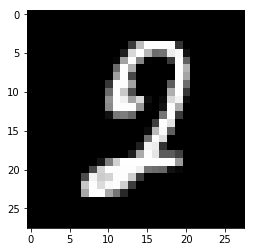

sample from variance minimization


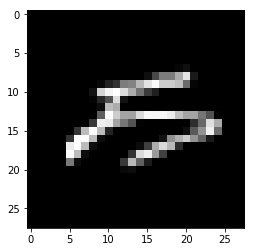

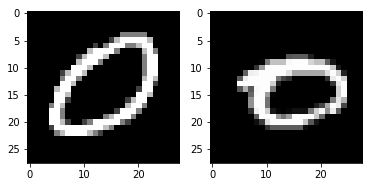

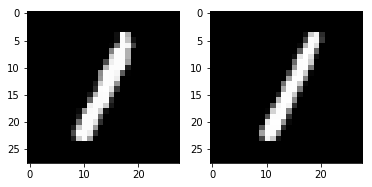

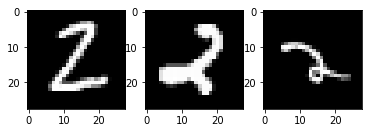

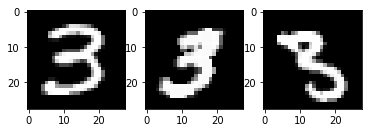

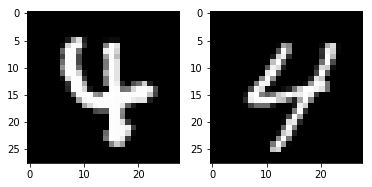

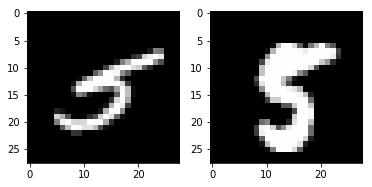

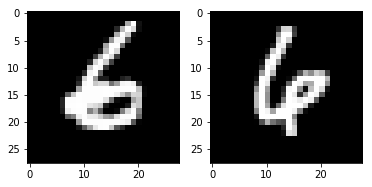

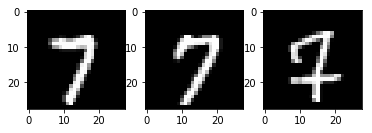

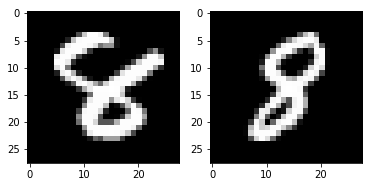

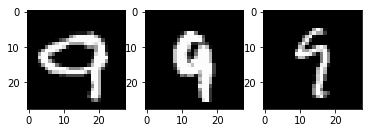

In [26]:
inds_lba = model.propose_samples(sup_images, sup_lbls, train_images, train_labels, sess, n_samples=1)
inds_min_var_logit = model.propose_samples_min_var_logit(sup_images, sup_lbls, train_images, train_labels, sess, n_samples=1)

print('sample from lba')
for i in inds_lba: show_sample(i) 
    
print('sample from variance minimization')
for i in inds_min_var_logit: show_sample(i) 
    
for imgs in sup_by_label: 
    show_sample_img_inline(imgs)   

In [28]:
# add sample
sample = inds_lba[0]

label = train_labels[sample]
img = train_images[sample]
sup_by_label[label] = np.vstack([sup_by_label[label],[img]])
print(label)

3


(1386,)
p 43.7576095581
ind [ 341  101  752 1181 1049  234  651  857   68 1344  396  281   20  581  657] (1386,)
indices [14286  4935 31748 50236 44767  9516 27503 36653  3290 57308 16549 11777
   943 24587 27822]
[341]
147.0


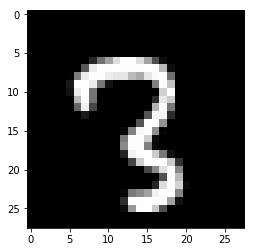

[101]
140.0


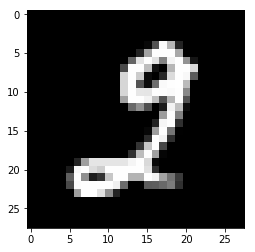

[752]
136.0


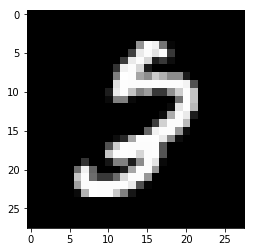

[1181]
138.0


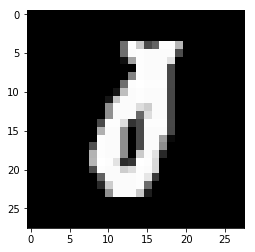

[1049]
128.0


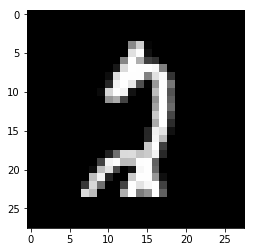

[234]
113.0


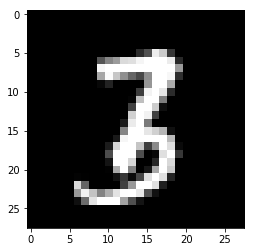

[651]
109.0


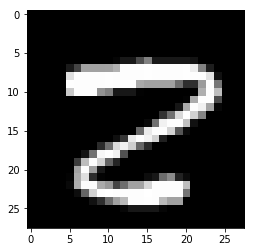

[857]
127.0


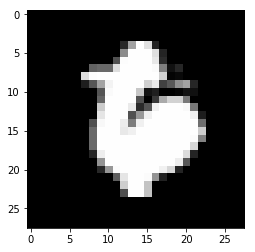

[68]
124.0


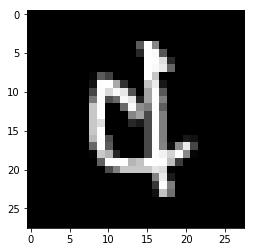

[1344]
109.0


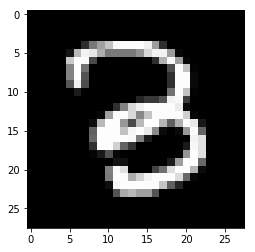

[396]
102.0


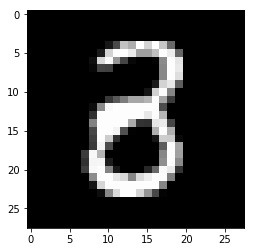

[281]
116.0


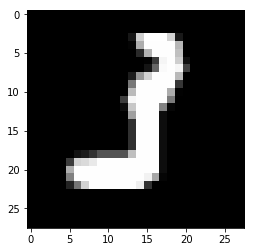

[20]
113.0


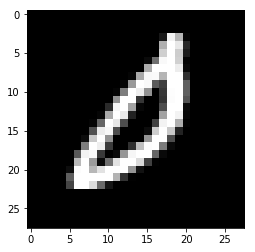

[581]
112.0


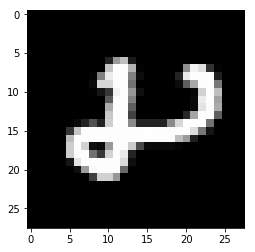

[657]
111.0


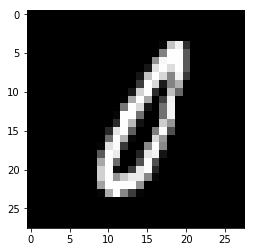

sample from lba


In [27]:
from backend import softmax, one_hot
def propose_samples(self, sup_imgs, sup_lbls, train_images, train_labels, sess, n_samples=1):    
    sup_embs = self.calc_embedding(sup_imgs, self.test_emb)
    train_embs = self.calc_embedding(train_images, self.test_emb)

    match_ab = np.dot(sup_embs, np.transpose(train_embs))
    p_ba = softmax(np.transpose(match_ab))

    # calculate sample confidence: sample confidence + confidence of close-by_samples
    sample_conf = np.var(p_ba, axis=1)
    thresh = 0.01

    unconf_sample_indices = np.where(sample_conf < thresh)[0][:10000]
    print(unconf_sample_indices.shape)
    unconf_train_embs = train_embs[unconf_sample_indices]
    #print(unconf_train_embs.shape, unconf_sample_indices)

    # distances to other unlabeled samples
    # not normalized
    p_bb = np.dot(unconf_train_embs, np.transpose(unconf_train_embs))

    # ignore faraway samples
    print('p', np.percentile(p_bb, 98))
    p_bb[p_bb < np.percentile(p_bb, 98)] = 0
    p_bb[p_bb > 1] = 1

    region_conf = np.dot(p_bb, sample_conf[unconf_sample_indices])

    #indices = np.argpartition(region_conf, kth=n_samples)[:n_samples]
    indices = np.argsort(-region_conf)[:n_samples]
    print('ind',indices, unconf_sample_indices.shape)
    or_indices = unconf_sample_indices[indices]
    print('indices', or_indices)
    
    
    for i in or_indices: 
        p_bb_ind = np.where(unconf_sample_indices == i)[0]
        print(p_bb_ind)
        print(np.sum(p_bb[p_bb_ind,:]))
        show_sample(i) 
    return or_indices

inds_lba = propose_samples(model, sup_images, sup_lbls, train_images, train_labels, sess, n_samples=15)

print('sample from lba')
    

(2396,)
p 43.3051652908
ind [1137 1687  610 1230 1289] (2396,)
indices [27406 40530 14367 29972 31284]
sample from lba


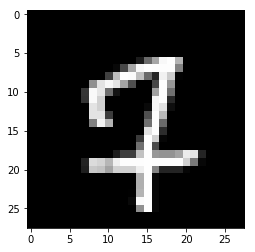

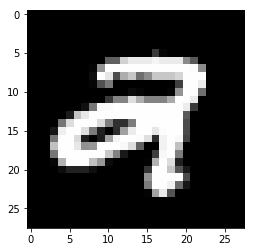

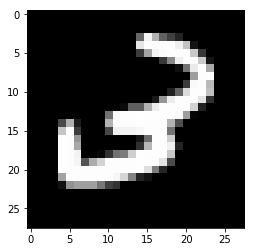

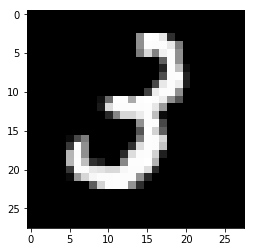

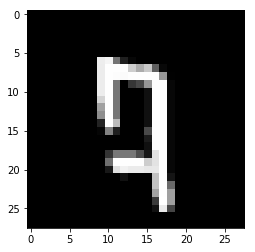

In [6]:
from backend import softmax, one_hot
def propose_samples(self, sup_imgs, sup_lbls, train_images, train_labels, sess, n_samples=1):    
    sup_embs = self.calc_embedding(sup_imgs, self.test_emb)
    train_embs = self.calc_embedding(train_images, self.test_emb)

    match_ab = np.dot(sup_embs, np.transpose(train_embs))
    p_ba = softmax(np.transpose(match_ab))

    # calculate sample confidence: sample confidence + confidence of close-by_samples
    sample_conf = np.var(p_ba, axis=1)
    thresh = 0.01
    sample_conf[sample_conf > thresh] = 4
    sample_conf[sample_conf < thresh] = -1

    unconf_sample_indices = np.where(sample_conf < 0)[0][:10000]
    print(unconf_sample_indices.shape)
    unconf_train_embs = train_embs[unconf_sample_indices]
    #print(unconf_train_embs.shape, unconf_sample_indices)

    # distances to other unlabeled samples
    # not normalized
    p_bb = np.dot(unconf_train_embs, np.transpose(unconf_train_embs))

    # ignore faraway samples
    print('p', np.percentile(p_bb, 95))
    p_bb[p_bb < np.percentile(p_bb, 95)] = 0
    p_bb[p_bb > 1] = 1

    region_conf = np.dot(p_bb, sample_conf[unconf_sample_indices])

    indices = np.argpartition(region_conf, kth=n_samples)[:n_samples]
    indices = np.argsort(region_conf)[:n_samples]
    print('ind',indices, unconf_sample_indices.shape)
    or_indices = unconf_sample_indices[indices]
    print('indices', or_indices)
    return or_indices

inds_lba = propose_samples(model, sup_images, sup_lbls, train_images, train_labels, sess, n_samples=5)

print('sample from lba')
for i in inds_lba: show_sample(i) 

In [ ]:
print(proposals)
show_sample(ind) for i in proposals

In [5]:
model.propose_samples

<bound method SemisupModel.propose_samples of <semisup.backend.SemisupModel object at 0x7fb381a8e240>>

20
[3 6 5 8 4 8 8 8 3 7 7 4 1 1 7 7 8 7 7 1]


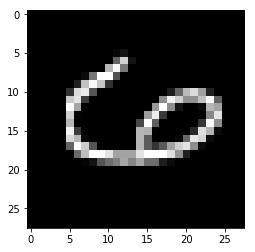

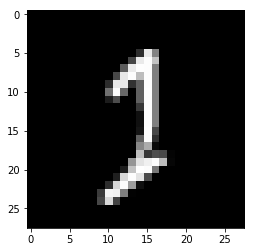

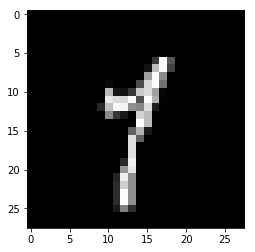

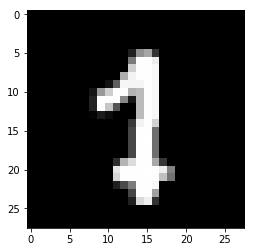

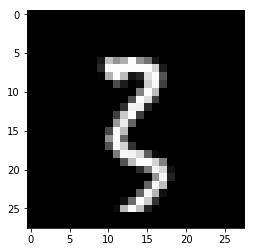

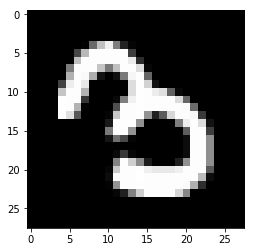

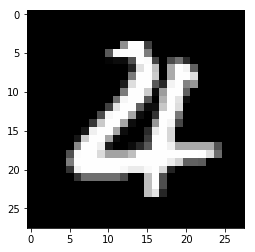

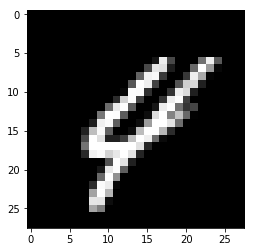

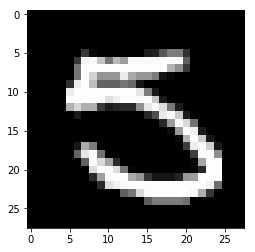

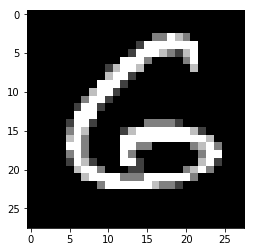

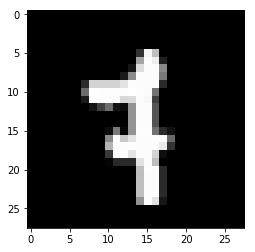

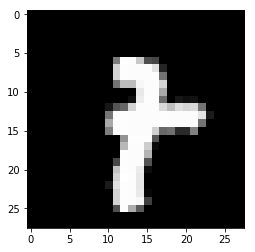

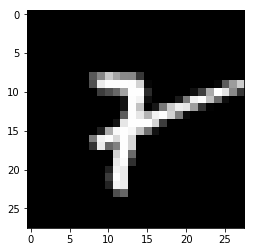

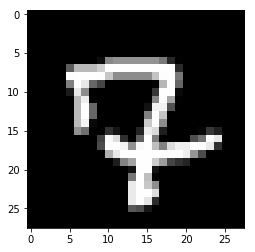

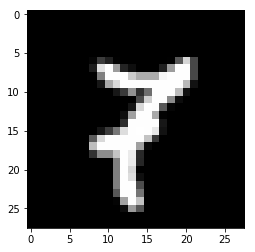

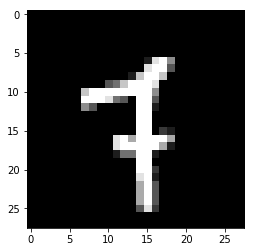

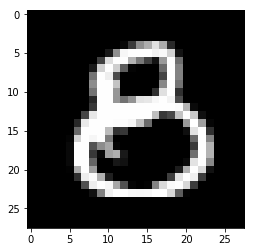

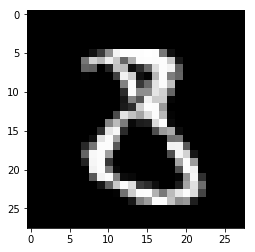

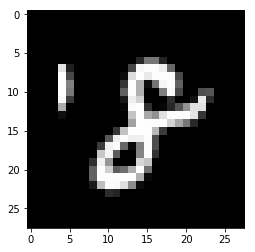

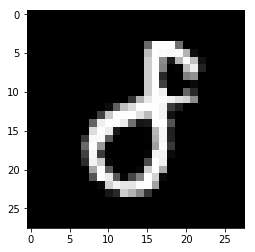

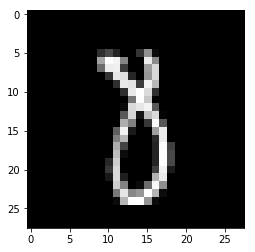

In [15]:


    
sup_inds = [374, 2507, 9755, 12953, 16507, 16873, 23474, 
            23909, 30280, 35070, 49603, 50106, 51171, 51726, 51805, 55205, 57251, 57296, 57779, 59154] + \
               [16644, 45576, 52886, 42140, 29201, 7767, 24, 134, 8464, 15022, 15715, 15602, 11030, 3898, 10195, 1454,
                3290, 5293, 5806, 274]
    
# from min var choice
sup_inds = [37921, 9924, 49041, 32926, 37926, 5828, 28492, 8045, 38408, 37118, 31717, 15108, 5602, 35482, 56292, 59653, 36834, 15450, 49529, 6839]

# lba with 7%
sup_inds = [31952, 24138, 39818, 501, 24589, 34532, 25954, 9924, 26338, 10716, 14062, 8853, 1940, 9251, 7767, 8196, 10044, 9348, 3204, 1127]

#lba with 15%
sup_inds = [9924, 34058, 53476, 15715, 6428, 33598, 33464, 41753, 21250, 26389, 12950, 12464, 3795, 6761, 5638, 3952, 8300, 5632, 1475, 1875]

sup_inds = [31952, 41018, 15066, 8584, 28556, 3512, 55395, 14062, 14655, 3010, 10716, 21262, 11342, 10048, 15106, 10014, 14128, 12464, 8196, 9550]
print(len(sup_inds))
print(train_labels[sup_inds])
show_sample(33790)

for i in range(10):
    for ind in sup_inds:
        if train_labels[ind] == i:
            show_sample(ind)

In [ ]:
def softmax(x):
    maxes = np.amax(x, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(x - maxes)
    dist = e / np.sum(e, axis=1).reshape(maxes.shape[0], 1)
    return dist

def one_hot(a, depth):
    b = np.zeros((a.size, depth))
    b[np.arange(a.size), a] = 1
    return b


with tf.Session(graph=graph) as sess:
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    FLAGS.checkpoint_dir = '/tmp/'
    ckpt = tf.train.get_checkpoint_state(FLAGS.checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

        
    sup_imgs, sup_lbls = model.get_images(t_sup_images, t_sup_labels, 1, sess)

    sup_embs = model.calc_embedding(sup_imgs, model.test_emb)
    train_embs = model.calc_embedding(train_images[0:10000,:], model.test_emb)

    match_ab = np.dot(sup_embs, np.transpose(train_embs))
    p_ba = softmax(np.transpose(match_ab))
    
    pred_ids = np.dot(p_ba, one_hot(sup_lbls, depth=model.num_labels))
    print(pred_ids.shape)
    preds = np.argmax(pred_ids, axis=1)
    corrects = (preds == train_labels[0:10000])
    
    cor_p_ba = p_ba[corrects]
    wrong_p_ba = p_ba[1-corrects]
    
    max_cor_ba = np.max(cor_p_ba, axis=1)
    print('avg p_ab for correct class for correct samples', np.mean(max_cor_ba > 0.65))
    
    max_wrong_ba = np.max(wrong_p_ba, axis=1)
    print('avg p_ab for incorrect class for incorrect samples', np.mean(max_wrong_ba > 0.65))
    
    # distances to other unlabeled samples
    # not normalized
    p_bb = np.dot(train_embs, np.transpose(train_embs))
    
    #ignore faraway samples
    print('p', np.percentile(p_bb, 95))
    p_bb[p_bb < np.percentile(p_bb, 95)] = 0
    p_bb[p_bb > 1] = 1
    
    # calculate region confidence: sample confidence + confidence of close-by_samples
    sample_conf = np.var(p_ba, axis = 1)
    print(np.mean(sample_conf), np.max(sample_conf), np.min(sample_conf))
    thresh = 0.01
    sample_conf[sample_conf > thresh] = 4
    sample_conf[sample_conf < thresh] = -1
    region_conf = np.dot(p_bb, sample_conf)
    
    cor_rc = region_conf[corrects]
    wrong_rc = region_conf[1-corrects]
    
    
    #print('avg region confidence for correct samples', np.mean(cor_rc))
    
    #print('avg region confidence for incorrect samples', np.mean(wrong_rc))
    
    indices = np.argpartition(region_conf, kth=model.num_labels)[:model.num_labels]
    print('indices', indices)
    
    for i in indices:
        show_sample(i)
        print('ii', i, train_labels[i], region_conf[i], sum(p_bb[i, :]))

    #find close by samples and visualize them
    close_by_indices = np.where( p_bb[am, :] > 0 )
    for samp in close_by_indices[0]:
        show_sample(samp)
    
    for img in sup_imgs:
        show_sample_img(img)
    
    
    # now, calculate the 'confidence' of the region around the sample
    
    print(p_bb.shape)
    print('0',p_bb[0])
    print('45',p_bb[45])
    print(np.argmax(p_bb[0]), p_bb[0][1634])
    print(np.argmax(p_bb[45]), p_bb[45][8837], p_bb[45][45])
    
    print(np.mean(np.diag(p_bb)))
    
    print(p_ba[1634,:])
    print(p_ba[8837,:])
    print(train_labels[45], train_labels[8837])
    coord.request_stop()
    coord.join(threads)

In [5]:
with sess:
    test_pred = model.classify(test_images).argmax(-1)
    print (np.mean(test_pred == test_labels))

RuntimeError: Attempted to use a closed Session.